# Sensor Placement Optimization

## functions.py

In [38]:
import os
import math
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

class boundary:
    def __init__(self, points):
        """
        points: a numpy array of x,y coordinate points that define the boundary of Ω (Ωs).  
        The points must be in sequential-clockwise order.
        """
        self.points = points
    
    @property
    def edges(self):
        ''' 
        edge_list: Returns a list of tuples that each contain the two vertices of an edge 
        '''
        edge_list = []
        for i in range(0,len(self.points)-1): #for each edge
            vertex1 = (self.points[i,0], self.points[i,1]) #first vertex
            vertex2 = (self.points[i+1,0], self.points[i+1,1]) #second vertex
            edge_list.append((vertex1,vertex2)) #save each edge as a tuple with the coordinates of the vertices

        #save the edge from the last point to the first point
        vertex1 = (self.points[-1,0], self.points[-1,1])
        vertex2 = (self.points[0,0], self.points[0,1])
        edge_list.append((vertex1,vertex2))

        return edge_list
         
    def contains(self, point):
        import sys
        _huge = sys.float_info.max
        _tiny = sys.float_info.min
        _eps = 0.00001

        # We start on the outside of the polygon
        inside = False
        for i in range(0,len(self.points)): #for each edge
            A, B = self.edges[i] #set A, B as the vertices of the edge
    
            #Reorder such that A is below B
            if A[1] > B[1]:
                A, B = B, A

            #Make notation easy to follow and write
            Ax = A[0]
            Ay = A[1]
            Bx = B[0]
            By = B[1]
            Px = point[0]
            Py = point[1]

            #Check if P is at the same height as A or B, and move it a small amount if so
            if (Py == Ay or Py == By):
                Py += _eps
            
            #Check if P is above, below, or to the right of the edge AB
            if (Py > By or Py < Ay or Px > max(Ax, Bx)):
                continue

            #Check if P is to the left of both A and B
            if Px < min(Ax, Bx):
                inside = not inside
                continue

            #Compare slopes of AB and AP.  Toggle boolean if AP is a greater slope.    
            if abs(Ax-Bx) > _tiny:
                m_edge = (By - Ay) / (Bx - Ax)
            else:
                m_edge = _huge
                
            if abs(Ax-Px) > _tiny:
                m_point = (Py - Ay) / (Px - Ax)
            elif Ax > Bx: #assign the correct sign to 'huge'
                m_point = -_huge 
            else:
                m_point = _huge

            if m_point > m_edge:
                # The ray intersects with the edge
                inside = not inside
                continue

        return inside

def centralPivot(r):
    
    '''
    Generates the a list of all pixels that would fit under a central pivot irrigation arm of length r
    '''
    
    X = []
    Y = []
    for x in range(-r,r):
        for y in range(-r,r):
            if (x**2)+(y**2)<=(r**2): 
                X.append((x))
                Y.append((y))
    pX = np.array([X])
    pY = np.array([Y])
    P = np.vstack((pX,pY)).T
                
    return P

def rectangle(length,width):
    
    X = []
    Y = []    
    for x in range(0,width):
        for y in range(0,length):
            X.append((x))
            Y.append((y))
    pX = np.array([X])
    pY = np.array([Y])
    P = np.vstack((pX,pY)).T
    
    return P
    
def rangeLimits(A): #(P), returns bounds
    
    '''
    Returns the bounds of a numpy array as a list of length 4, corresponding 
    to (xmin, xmax, ymin, ymax)
    '''
    
    xmin = np.amin(A[:,0])
    xmax = np.amax(A[:,0])
    ymin = np.amin(A[:,1])
    ymax = np.amax(A[:,1])
    return (xmin, xmax, ymin, ymax) 
    
def distancefromPoint(p1,p2):
    
    '''
    Calculates and returns the scalar distance between two points
    '''
    
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    ans = np.sqrt(np.square(x2-x1)+np.square(y2-y1))
    return ans

def rayTrace(q,b): #(agriculturalField,bounds), returns fieldPixels
    
    '''
    Sweeps through each pixel in the range and determines whether or not 
    the pixel is within the enclosed boundary polygon
    '''
    
    X = []
    Y = []
    for x in range(round(b[0]),round(b[1])):
        for y in range(round(b[2]),round(b[3])):
            if q.contains([x, y]) == True:
                X.append((x))
                Y.append((y))
    aX = np.array([X])
    aY = np.array([Y])
    A = np.vstack((aX,aY)).T
    return A

def theoreticalBest(N,R,A):#(numberSensors,coverageRadius,fieldPixels)
    total = 0
    for x in range(-R-1,R+1):
        for y in range(-R-1,R+1):
            #if point within range of any sensor, count point as within range and continue to next point
            distance = distancefromPoint([x,y],[0,0])
            if distance <= R:
                total += 1
        
    return N*total/len(A[:,0])

def generateDesigns(variables,N,l,b,designs): 
    #(geneticVariables,numberSensors,loopNumber,bounds,designMatrix), returns designMatrix
    
    '''
    Generates designMatrix for a given number of sensors, where the columns of indices
    2N hold x-coordinates of sensors and columns of indices 2N+1 hold y-coordinates
    The final column of the designMatrix is returned as 0 and is scored with the fitness function later
    '''
    
    S = variables[0] #population
    P = variables[1] #parents
    C = variables[2] #children
    
    n = P+C if l > 0 else 0 #select where in the designMatrix to start generating strings
    for i in range(n,S):
        for j in range(0,N):
            
            #generate a random x-coordinate
            phi = random.rand() #random number 0-1
            xi = int(round(phi*(b[1]-b[0])+b[0])) #pick random x-coordinate within xmin:xmax
            
            #generate a random y-coordinate
            phi = random.rand() #random number 0-1
            yi = int(round(phi*(b[3]-b[2])+b[2])) #pick random y-coordinate within ymin:ymax
            
            #input the coordinates into the design matrix
            designs[i,(2*j)] = xi
            designs[i,(2*j)+1] = yi
            
    return designs

def fitness(P,S,N,A,designs,radius): 
    #(parents,population,numberSensors,fieldPixels,designMatrix,coverageRadius), returns designMatrix with scores
    
    '''
    Scores the designMatrix on a scale from 0-1, where 1 is 100% coverage of
    the field pixels with sensors
    '''
    
    coverage = 0
    for i in range(P,S): #for each design
        for j in range(0,len(A[:,0])): #for each point in the field
            for k in range(0,N): # for all sensors

                #if point within range of any sensor, count point as within range and continue to next point
                distance = distancefromPoint(A[j,:],[designs[i,(2*k)],designs[i,(2*k)+1]])
                if distance <= radius:
                     coverage += 1
                     break

        #Score the design
        designs[i,-1] = coverage/len(A[:,0])
        coverage = 0
    return designs

def mutate_randomReset(designs,variables,b):#(designMatrix,geneticVariables,bounds)
    
    '''
    Randomly mutates one coordinate of the children designs
    '''
    
    #These lines determine where in the designMatrix to start searching
    S = variables[0] #population
    P = variables[1] #parents
    C = variables[2] #children
    
    for j in range(P,P+C): #for each of the children strings
        designMatrix[j,:] = designMatrix[j-P,:] #as this loops, it will overwrite bad strings with parent string values
        coordinateSelect = random.randint(0,len(designMatrix[j,:])-1) #pick a random sensor coordinate in the string
        
        if (coordinateSelect % 2) == 0: #if the selected mutation is a x-coordinate
            permissibleRange = (b[0],b[1]) # make permissible mutation coordinate range between xmin:xmax
        else: #else if a y coordinate
            permissibleRange = (b[2],b[3]) #permissible mutation range is ymin:ymax
        
        designMatrix[j,coordinateSelect] = random.randint(permissibleRange[0],permissibleRange[1])
    
    return designMatrix

## main.py

In [39]:
'''
Choose method for defining the field
'''



'''Uncomment For User-Defined Boundary - Online Example'''

# #Define some number of boundary points in the field as a numpy array of x,y coordinates 
# P = np.array([[0, 0], [0, 61],[55, 143],[101, 143],[123, 110],[101, 61],[55,61],[55,0]])

# # #Upper and Lower Limit Bounds
# bounds = rangeLimits(P)

# #Generate the agricultural field as a boundary of interconnected boundary points, P, with ray tracing capability
# agriculturalField = boundary(P)

# #Generate an Ax2 array of points within the boundary, Ω
# fieldPixels = rayTrace(agriculturalField,bounds)

# # Define the coverage radius of the sensor
# coverageRadius = 8
# print('The effective coverage radius of the device is ' +str(10*coverageRadius) + ' meters')

'''Uncomment for small family farm'''

# #Define some number of boundary points in the field as a numpy array of x,y coordinates 
# fieldLength = 18 #corresponding to y-coordinate
# fieldWidth = 8 #corresponding to x-coordinate

# # Define the coverage radius of the sensor
# coverageRadius = 1
# print('The effective coverage radius of the device is ' +str(coverageRadius) + ' meters')

# # #Upper and Lower Limit Bounds
# bounds = (-coverageRadius,fieldWidth+coverageRadius-1,-coverageRadius,fieldLength+coverageRadius-1)

# #Generate an Ax2 array of points within the boundary, Ω
# fieldPixels = rectangle(fieldLength,fieldWidth)

'''Uncomment For Central Pivot'''

# #Generate an Ax2 array of points within the boundary, Ω
# fieldPixels = centralPivot(40)
# print('The area of the field is approximately ' + str(100*len(fieldPixels[:,0])) + ' meters squared')

# #Upper and Lower Limit Bounds
# bounds = rangeLimits(fieldPixels)

# # Define the coverage radius of the sensor
# coverageRadius = 8
# print('The effective coverage radius of the device is ' + str(10*coverageRadius) + ' meters')

'''Uncomment For User-Defined Boundary - Hybrid-Type Field'''

# #Define some number of boundary points in the field as a numpy array of x,y coordinates 
# P = np.array([[0,20],[0,40],[3,40],[3,45],[5,50],[9,54],[13,57],[18,59],[23,60],[28,59],[33,57],\
# [37,54],[63,20],[63,0],[43,0],[43,20]])

# # #Upper and Lower Limit Bounds
# bounds = rangeLimits(P)

# #Generate the agricultural field as a boundary of interconnected boundary points, P, with ray tracing capability
# agriculturalField = boundary(P)

# #Generate an Ax2 array of points within the boundary, Ω
# fieldPixels = rayTrace(agriculturalField,bounds)

# # Define the coverage radius of the sensor
# coverageRadius = 8
# print('The effective coverage radius of the device is ' +str(coverageRadius) + ' meters')


#########################################################################################################################


'''Program Start'''

#Define Genetic Algorithm Variables
population = 30 
parents = 5 #number of parent designs kept in each iteration
children = 5 #number of children designs made & kept in each iteration
geneticVariables = (population, parents, children)
N_0 = 1 #Number of devices in the initial design

#Define exit criteria for the genetic loop
maxLoops = 300 #how many loops that occur for a given N before the program stops because it is taking too long
convergenceCheck = 30 #loops that can occur with the same fitness score before it is considered 'converged'
N_max = 50
idealBest = theoreticalBest(N_0,coverageRadius,fieldPixels)


#Error Checks
if maxLoops < convergenceCheck:
    raise Exception('The maximum number of loops must be greater than the minimum number of convergence loops')
if parents > population:
    raise Exception('The number of parent designs cannot exceed the total population of designs')

    
'''
Generate a global design matrix that will store the highest scoring design in designMatrix
Each row is the best design found for N sensors, where N is the row number + 1
Each row is a design where every two columns is an x,y coordinate of a sensor positioned within the field
The last value in each row is the fitness score (from 0-1)
Used for plotting the percentage of field coverage possible for N sensors
'''
globaldesignMatrix = []

'''
Generate a scoring vector that records the 'best' design's fitness for each loop in the genetic algorithm
Used for plotting how the genetic algorithm 'learns' and improves itself over time
Also used for determining when the algorithm converges on for a given 'N'
'''
bestFitness = np.zeros((maxLoops,1))

'''
globalFitness
'''

globalFitness = np.zeros((maxLoops,N_max-N_0+1))

#Initialize Genetic Algorithm Counters
loopNumber = 0
numberSensors = N_0
print('Solving for ' + str(numberSensors) + ' sensors')


#Genetic Loop
while(bestFitness[loopNumber] < 1):
    
    #Initialize designMatrix if this is the first loop for this N
    if loopNumber == 0: designMatrix = np.zeros((population,(numberSensors*2)+1))

    #Generate Designs
    '''
    Define a matrix of 'designs' of size S x (2N+1)
    Each row is a design where every two columns is an x,y coordinate of a sensor positioned within the field
    The last column of each row is reserved for the fitness score (from 0-1)
    Used for calculating and ranking the fitness function in the genetic algorithm
    '''
    designMatrix = generateDesigns(geneticVariables,numberSensors,loopNumber,bounds,designMatrix)

    #Calculate Fitness
    if loopNumber == 0: skipParents = 0 
    else: skipParents=parents #don't need to rescore the parents that were saved
    designMatrix = fitness(skipParents,population,numberSensors,fieldPixels,designMatrix,coverageRadius)

    #Rank Each Design
    ind = np.argsort(designMatrix[:,-1])[::-1] #remove the [::-1] to sort in ascending order
    designMatrix = designMatrix[ind]

    #Store the highest scoring design for future plotting
    bestFitness[loopNumber] = designMatrix[0,-1]

    #Check if full coverage has been achieved
    if bestFitness[loopNumber] == 1: 
        globaldesignMatrix.append(designMatrix[0,:])
        print('The field can be completely covered with ' + str(numberSensors) + '!')
        break
            
    #Check if the theoretical best design value was reached
    if (bestFitness[loopNumber] >= idealBest):
        
        #store the best design for this N
        globaldesignMatrix.append(designMatrix[0,:])
        globalFitness[:,numberSensors-N_0] = bestFitness[:,0]
        
        #print the exit condition
        print('The theoretical best coverage condition was met')
        
        #Reset counters, the design matrix, and the scoring vector.
        numberSensors += 1
        if numberSensors == N_max+1: # +1 is because N is iterated at the end of the loop
            print('The max number of sensors has been reached')
            break
        print('Solving for ' + str(numberSensors) + ' sensors')
        idealBest = theoreticalBest(numberSensors,coverageRadius,fieldPixels)
        loopNumber = 0
        bestFitness = np.zeros((maxLoops,1))
    
    #Check if the algorithm has converged on a solution
    elif ((loopNumber > convergenceCheck) and \
    ((bestFitness[loopNumber] == bestFitness[loopNumber-convergenceCheck]) or \
    loopNumber == maxLoops-1)):
        
        #store the best design for this N
        globaldesignMatrix.append(designMatrix[0,:])
        globalFitness[:,numberSensors-N_0] = bestFitness[:,0]
        
        #print the exit condition
        if (bestFitness[loopNumber] >= 1): 
            print('The field can be completely covered with ' + str(numberSensors) + ' sensors')
            break

        if (loopNumber == maxLoops-1):
            print('The maximum number of loops have been reached')
        
        #Reset counters, the design matrix, and the scoring vector.
        numberSensors += 1
        if numberSensors == N_max+1: # +1 is because N is iterated at the end of the loop
            print('The max number of sensors has been reached')
            break
        print('Solving for ' + str(numberSensors) + ' sensors')
        idealBest = theoreticalBest(numberSensors,coverageRadius,fieldPixels)
        loopNumber = 0
        bestFitness = np.zeros((maxLoops,1))    

    #If convergence has NOT occured, then loop through
    else:               
        
        #Mutate Designs
        designMatrix = mutate_randomReset(designMatrix,geneticVariables,bounds)
        
        #Loop
        loopNumber += 1
        
print('End of Program')

The effective coverage radius of the device is 1 meters
Solving for 1 sensors
The theoretical best coverage condition was met
Solving for 2 sensors
The theoretical best coverage condition was met
Solving for 3 sensors
The theoretical best coverage condition was met
Solving for 4 sensors
The theoretical best coverage condition was met
Solving for 5 sensors
The theoretical best coverage condition was met
Solving for 6 sensors
The theoretical best coverage condition was met
Solving for 7 sensors
The theoretical best coverage condition was met
Solving for 8 sensors
The theoretical best coverage condition was met
Solving for 9 sensors
The theoretical best coverage condition was met
Solving for 10 sensors
The theoretical best coverage condition was met
Solving for 11 sensors
The theoretical best coverage condition was met
Solving for 12 sensors
The theoretical best coverage condition was met
Solving for 13 sensors
Solving for 14 sensors
Solving for 15 sensors
Solving for 16 sensors
Solving f

## plotting.py

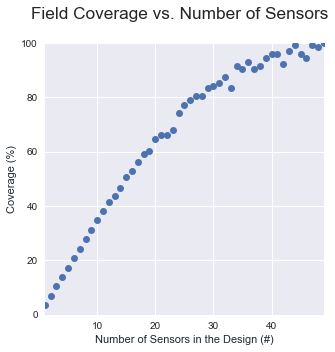

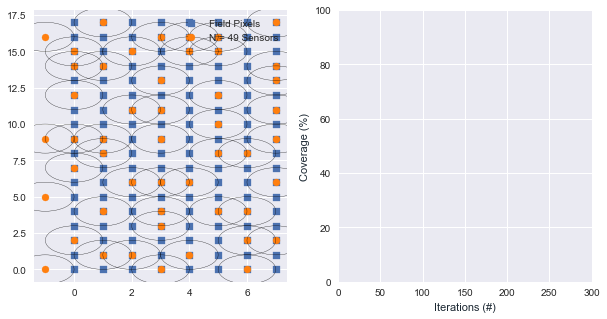

In [41]:
'''
Function Definitions
'''

def plotDesigns(N_0,A,designs,fitness,radius):#(N_0,fieldPixels,globaldesignMatrix,globalFitness,coverageRadius)
    
    '''
    Plots the coordinates of where to place sensors as
    over the field pixels for each number of sensors
    '''
    
    numberDesigns = len(designs)
    minSensors = N_0
    maxSensors = N_0 + numberDesigns - 1
    
    #Build Subplot Architecture
    plt.style.use('seaborn')    
    fig, axs = plt.subplots(numberDesigns,2,figsize=(10,5*numberDesigns))
    cols = ['Optimized Sensor Positions','Development of Objective Function']
    for ax, col in zip(axs[0], cols):
        ax.set_title(col)
        
    #Fill in the Subplots
    for n in range(numberDesigns):
        
        #Plot Sensor Positions with Coverage
        thisDesign = designs[n]
        x = thisDesign[0:-2:2]
        y = thisDesign[1:-1:2]
        axs[n,0].scatter(A[:,0], A[:,1], marker = 's')
        axs[n,0].scatter(x, y, color = '#ff7f0e', label='N = {} Sensors'.format(n+N_0))
        axs[n,0].legend(loc='upper right')
        circles = []
        for i in range(len(x)):
            newCircle = plt.Circle((x[i],y[i]), radius, fill=False)
            axs[n,0].add_artist(newCircle)
        plt.setp(axs[n,0],xlabel = 'x (m)')
        plt.setp(axs[n,0],ylabel = 'y (m)')
        
        #Plot Convergence
        thisFitness = fitness[:,n]*100
        y = np.ma.masked_equal(thisFitness,0).compressed()
        x = np.linspace(1,len(y),len(y))
        axs[n,1].plot(x,y,label = 'N = {} Sensors'.format(n+1))
        axs[n,1].set_xlim([0, len(thisFitness)])
        axs[n,1].set_ylim([0, 100])
        plt.setp(axs[n,1],xlabel = 'Iterations (#)')
        plt.setp(axs[n,1],ylabel = 'Coverage (%)')

def plotthisDesign(N_0,A,designs,radius,fitness,N):#(startingnumberSensors,fieldPixels,globaldesignMatrix,coverageRadius,globalFitness,designNumber)
        
    '''
    Plots the coordinates of where to place sensors 
    over the field pixels for the N sensor design
    '''
    
    #Build Subplot Architecture
    plt.style.use('seaborn')
    fig, axs = plt.subplots(1,2,figsize=(10, 5))
    
    #Fill in the Subplots
    thisDesign = designs[N-N_0]
    x = thisDesign[0:-2:2]
    y = thisDesign[1:-1:2]
    axs[0].scatter(A[:,0], A[:,1], marker = 's', label='Field Pixels')
    axs[0].scatter(x, y, color = '#ff7f0e', label='N = {} Sensors'.format(N))
    axs[0].legend(loc='upper right')
    circles=[]
    for i in range(len(x)):
        newCircle = plt.Circle((x[i],y[i]), radius, fill=False)
        axs[0].add_artist(newCircle)
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    
    #Plot Convergence
    thisFitness = fitness[:,N-N_0]*100
    y = np.ma.masked_equal(thisFitness,0).compressed()
    x = np.linspace(1,len(y),len(y))
    axs[1].plot(x,y,label = 'N = {} Sensors'.format(N))
    axs[1].set_xlim([0, len(thisFitness)])
    axs[1].set_ylim([0, 100])
    plt.setp(axs[1],xlabel = 'Iterations (#)')
    plt.setp(axs[1],ylabel = 'Coverage (%)')
    
def graphCoverage(N_0,designs):#(N_0,globaldesignMatrix)
    
    '''
    Make a scatter plot that shows the percent field coverage achievable by varying the number of sensors used
    '''
    
    #Build Subplot Architecture
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize = [5,5])
    
    #Fill in the Subplots
    numberDesigns = len(designs)
    minSensors = N_0
    maxSensors = N_0 + numberDesigns - 1
    coverage = []
    for n in range(numberDesigns):
        thisDesign = designs[n]
        coverage.append(thisDesign[-1]*100)
    numberSensors = np.linspace(minSensors,maxSensors,num=numberDesigns).astype('int')  #assumes increasing numberSensors += 1
    plt.plot(numberSensors,coverage, 'o')
    fig.suptitle('Field Coverage vs. Number of Sensors', size = 'xx-large')
    plt.xlabel('Number of Sensors in the Design (#)', color='#1C2833')
    plt.ylabel('Coverage (%)', color='#1C2833')
    ax.set_xlim([minSensors, maxSensors])
    ax.set_ylim([0, 100])
    plt.show()
    

    
'''
Plotting & Reporting
'''
graphCoverage(N_0,globaldesignMatrix)
# plotDesigns(N_0,fieldPixels,globaldesignMatrix,globalFitness,coverageRadius)
plotthisDesign(N_0,fieldPixels,globaldesignMatrix,coverageRadius,globalFitness,49)


In [ ]:
print(designMatrix)

[Text(0, 0.5, 'Coverage (%)')]

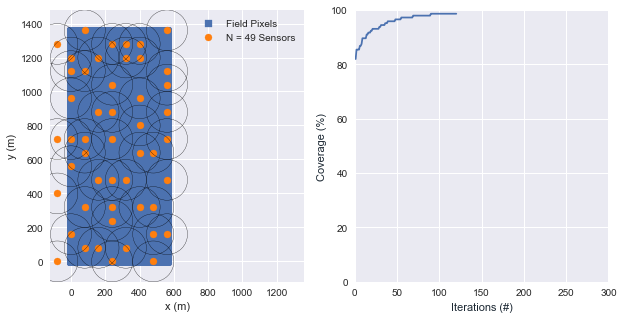

In [45]:
# actualrectangularField(coverageRadius,globaldesignMatrix):


N = 49
N_0 = 1


fieldLength = 18
fieldWidth = 8
coverageRadius = 1
actualRadius = 80
reductionRatio = actualRadius/coverageRadius
actualRadius = 120

actualfieldLength = int((fieldLength-1)*reductionRatio) #corresponding to y-coordinate
actualfieldWidth = int((fieldWidth-1)*reductionRatio) #corresponding to x-coordinate

#Generate an Ax2 array of points within the boundary, Ω
fieldPixels = rectangle(actualfieldLength,actualfieldWidth)

#Build Subplot Architecture
plt.style.use('seaborn')
fig, axs = plt.subplots(1,2,figsize=(10, 5))

thisDesign = globaldesignMatrix[-1]
x = thisDesign[0:-2:2] * reductionRatio
y = thisDesign[1:-1:2] * reductionRatio
axs[0].scatter(fieldPixels[:,0], fieldPixels[:,1], marker = 's', label='Field Pixels')
axs[0].scatter(x, y, color = '#ff7f0e', label='N = {} Sensors'.format(N))
axs[0].legend(loc = 'upper right')
circles=[]
for i in range(len(x)):
    newCircle = plt.Circle((x[i],y[i]), actualRadius, fill=False)
    axs[0].add_artist(newCircle)
    plt.setp(axs[0],xlabel = 'x (m)')
    plt.setp(axs[0],ylabel = 'y (m)')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
axs[0].set_xlim([-actualRadius,actualfieldLength])
axs[0].set_ylim([-actualRadius,actualfieldLength+actualRadius])


#Plot Convergence
thisFitness = globalFitness[:,N-N_0-1]*100
y = np.ma.masked_equal(thisFitness,0).compressed()
x = np.linspace(1,len(y),len(y))
axs[1].plot(x,y,label = 'N = {} Sensors'.format(N))
axs[1].set_xlim([0, len(thisFitness)])
axs[1].set_ylim([0, 100])
plt.setp(axs[1],xlabel = 'Iterations (#)')
plt.setp(axs[1],ylabel = 'Coverage (%)')

#     return (actualRadius,x,y,fieldPixels)


# plotthisDesign(N_0,fieldPixels,globaldesignMatrix,coverageRadius,globalFitness,50)

In [ ]:
# actualcentralpivotScale(coverageRadius,globaldesignMatrix):
    
N = 50
N_0 = 1
fieldPixels = centralPivot(400)
actualRadius = 80
reductionRatio = actualRadius/coverageRadius

#Build Subplot Architecture
plt.style.use('seaborn')
fig, axs = plt.subplots(1,2,figsize=(10, 5))

thisDesign = globaldesignMatrix[-1]
x = thisDesign[0:-2:2] * reductionRatio
y = thisDesign[1:-1:2] * reductionRatio
axs[0].scatter(fieldPixels[:,0], fieldPixels[:,1], marker = 's', label='Field Pixels')
axs[0].scatter(x, y, color = '#ff7f0e', label='N = {} Sensors'.format(N))
axs[0].legend()
circles=[]
for i in range(len(x)):
    newCircle = plt.Circle((x[i],y[i]), actualRadius, fill=False)
    axs[0].add_artist(newCircle)
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')

#Plot Convergence
thisFitness = globalFitness[:,N-N_0]*100
y = np.ma.masked_equal(thisFitness,0).compressed()
x = np.linspace(1,len(y),len(y))
axs[1].plot(x,y,label = 'N = {} Sensors'.format(N))
axs[1].set_xlim([0, len(thisFitness)])
axs[1].set_ylim([0, 100])
plt.setp(axs[1],xlabel = 'Iterations (#)')
plt.setp(axs[1],ylabel = 'Coverage (%)')

#     return (actualRadius,x,y,fieldPixels)


# plotthisDesign(N_0,fieldPixels,globaldesignMatrix,coverageRadius,globalFitness,50)

[Text(0, 0.5, 'Coverage (%)')]

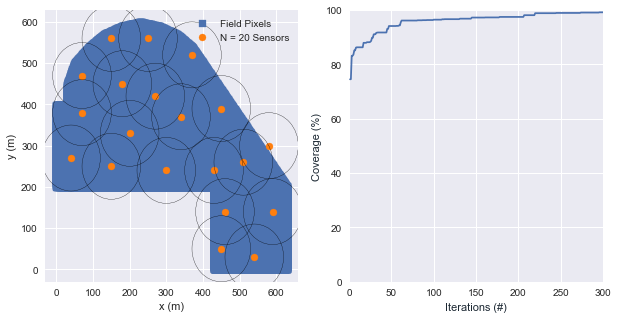

In [49]:
#actual hybrid field plot

# N = 20
# N_0 = 1

# # #Define some number of boundary points in the field as a numpy array of x,y coordinates 
# P = np.array([[0,200],[0,400],[30,400],[30,450],[50,500],[90,540],[130,570],[180,590],[230,600],[280,590],[330,570],\
# [370,540],[630,200],[630,0],[430,0],[430,200]])

# # #Upper and Lower Limit Bounds
# bounds = rangeLimits(P)

# # #Generate the agricultural field as a boundary of interconnected boundary points, P, with ray tracing capability
# agriculturalField = boundary(P)

# # #Generate an Ax2 array of points within the boundary, Ω
# fieldPixels = rayTrace(agriculturalField,bounds)

# # # Define the coverage radius of the sensor
# coverageRadius = 8
# actualRadius = 80
# reductionRatio = actualRadius/coverageRadius

#Build Subplot Architecture
plt.style.use('seaborn')
fig, axs = plt.subplots(1,2,figsize=(10, 5))

thisDesign = globaldesignMatrix[-1]
x = thisDesign[0:-2:2] * reductionRatio
y = thisDesign[1:-1:2] * reductionRatio
axs[0].scatter(fieldPixels[:,0], fieldPixels[:,1], marker = 's', label='Field Pixels')
axs[0].scatter(x, y, color = '#ff7f0e', label='N = {} Sensors'.format(N))
axs[0].legend(loc = 'upper right')
circles=[]
for i in range(len(x)):
    newCircle = plt.Circle((x[i],y[i]), actualRadius, fill=False)
    axs[0].add_artist(newCircle)
    plt.setp(axs[0],xlabel = 'x (m)')
    plt.setp(axs[0],ylabel = 'y (m)')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
# axs[0].set_xlim([-actualRadius,actualfieldLength])
# axs[0].set_ylim([-actualRadius,actualfieldLength+actualRadius])


#Plot Convergence
thisFitness = globalFitness[:,N-N_0]*100
y = np.ma.masked_equal(thisFitness,0).compressed()
x = np.linspace(1,len(y),len(y))
axs[1].plot(x,y,label = 'N = {} Sensors'.format(N))
axs[1].set_xlim([0, len(thisFitness)])
axs[1].set_ylim([0, 100])
plt.setp(axs[1],xlabel = 'Iterations (#)')
plt.setp(axs[1],ylabel = 'Coverage (%)')


## Save Data to a File

In [42]:
import pickle

myData = [globaldesignMatrix, globalFitness, fieldPixels, N_0, coverageRadius]
file = 'family farm, maxLoops = 300, convergenceCheck = 30, mutations ON'

print('Warning! Have you changed the filename yet?  If not - you WILL overwrite data that took a looooong time to generate.')
print('Is ' + file +' the correct file name?')
breakpoint()

f = open(file, 'wb')
pickle.dump(myData, f)
f.close()

Warning! Have you changed the filename yet?  If not - you WILL overwrite data that took a looooong time to generate.
Is family farm, maxLoops = 300, convergenceCheck = 30, mutations ON the correct file name?
--Return--
None
> <ipython-input-42-1f30c88ed06d>(8)<module>()
      6 print('Warning! Have you changed the filename yet?  If not - you WILL overwrite data that took a looooong time to generate.')
      7 print('Is ' + file +' the correct file name?')
----> 8 breakpoint()
      9 
     10 f = open(file, 'wb')

ipdb> c


## Load data from a file

In [46]:
import pickle

file = 'hybrid field, maxLoops = 300, convergenceCheck = 30, mutations ON'

f = open(file, 'rb')
[globaldesignMatrix, globalFitness, fieldPixels, N_0, coverageRadius] = pickle.load(f)
f.close()

## Archive of file names and descriptions

Append this list anytime new data is gathered

'center pivot, maxLoops = 1000, convergenceCheck = 50, mutations ON' \
'center pivot, maxLoops = 100, convergenceCheck = 10, mutations OFF' \
'center pivot, maxLoops = 100, convergenceCheck = 10, mutations ON' \
'hybrid field, maxLoops = 300, convergenceCheck = 30, mutations ON' \
'family farm, maxLoops = 300, convergenceCheck = 30, mutations ON, N=1-40'\
'family farm, maxLoops = 300, convergenceCheck = 30, mutations ON, N=41-60' \
'family farm, maxLoops = 300, convergenceCheck = 30, mutations ON' \
'central pivot, maxLoops = 300, convergenceCheck = 30, mutations ON'

# Misc & Testing

In [13]:
# path = "\Users\Payton Goodrich\"
# name = 'globalFitness.txt'

# try:
#     file = open(join(path, name),'w')   # Trying to create a new file or open one
#     file.write('test')
#     file.close()
            
# except:
#     print('Uh oh speghetti-o')

# np.set_printoptions(threshold=np.inf)    
# print(fieldPixels)

# plt.style.use('seaborn')    
# fig, axs = plt.subplots()
# axs.scatter(fieldPixels[:,0], fieldPixels[:,1], marker = 's')

# print(P)

# elemeno = P*(20/7)
# print(elemeno)


# print(designMatrix[0,:])

# print(loopNumber)
# print(designMatrix)
# print(idealBest)
# print(len(fieldPixels[:,0]))
# print('Warning! About to solve without mutations.'')
# print('Reset the children variable to 5 and uncomment out the mutation line of code at the end of this block.')
# print('Continue?')
# breakpoint()
print(fieldLength)


8697520


In [10]:
width=10
length=5

X = []
Y = []    
for x in range(0,width):
    for y in range(0,length):
        X.append((x))
        Y.append((y))
pX = np.array([X])
pY = np.array([Y])
P = np.array([[X, Y]])
print(P)

[[[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6
   7 7 7 7 7 8 8 8 8 8 9 9 9 9 9]
  [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4
   0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]]]


In [37]:
# print(designMatrix)
qq = 0
for j in designMatrix[:,1]:
    for e,i in enumerate(designMatrix[1,:]):
        print(e, i)
#          if e % 2 == 0:
#             print(e)
#          else:
#             print('nope')
    qq+=1
print(qq)

0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9 10.0
10 6.0
11 6.0
12 3.0
13 8.0
14 3.0
15 14.0
16 2.0
17 6.0
18 2.0
19 1.0
20 0.3402777777777778
0 6.0
1 1.0
2 5.0
3 13.0
4 0.0
5 11.0
6 1.0
7 16.0
8 4.0
9

###### def plotAll(A,designs,radius):#(fieldPixels,globaldesignMatrix,coverageRadius)
    
    '''
    Plots the sensor locations as circles with an effective radius 
    over the field pixels for each number of sensors
    '''
    
    numberDesigns = len(designs)
    colors = ('r','g','b','c','m','y','k','w')
    plt.style.use('seaborn')
    fig, ax = plt.subplots() 
    ax.scatter(A[:,0], A[:,1], marker = 's', label='Field Pixels')
    for n in range(numberDesigns):     
        thisDesign = designs[n]
        x = thisDesign[0:-2:2]
        y = thisDesign[1:-1:2]
        circles = []
        for i in range(len(x)):
            newCircle = plt.Circle((x[i],y[i]), radius, color = colors[n], fill=False)
            ax.add_artist(newCircle)
    fig.suptitle('Agricultural Field represented by 1m\u00b2 pixels')
    ax.legend()
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')